### Student Information
Name: 黃恩平

Student ID: 111033622

GitHub ID: npinghuang

---

### Instructions

1. First: do the **take home** exercises in the [DM2022-Lab1-Master](https://github.com/keziatamus/DM2022-Lab1-Master). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2022-Lab1-Master](https://github.com/keziatamus/DM2022-Lab1-Master) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The dataset contains a `sentence` and `score` label. Read the specificiations of the dataset for details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be habdled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/keziatamus/DM2022-Lab1-Homework/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 20th 11:59 pm, Thursday)__. 

## 0. The Preparation

In [28]:
### Begin Assignment Here
# TEST necessary for when working with external scripts
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import sklearn
import helpers.data_mining_helpers as dmh
import nltk
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. The Data

In [2]:
FOLDER = 'sentiment labelled sentences/sentiment labelled sentences/'
filepath_dict = {'amazon': 'amazon_cells_labelled.txt', 'imbd'  : 'imdb_labelled.txt', 'yelp'  : 'yelp_labelled.txt'}

tmp_data = []
i = 0
for NAME, PATH in filepath_dict.items():
    tmp_data.append(pd.read_csv(FOLDER + PATH, sep = '\t', header=None, names=['sentence', 'score'], engine = 'python', quoting=3))
    # add source name to data
    tmp_data[i]['source_name'] = NAME
    i = i +1
DATA = pd.concat(tmp_data, ignore_index=True)
print(DATA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence     3000 non-null   object
 1   score        3000 non-null   int64 
 2   source_name  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None


##### Note :
In **'imdb_labelled.txt'**, there are many sentences with only one **"**. Which **pandas** need to scan another **"** for it to function properly. To fix this, I found a solution on [stackoverflow](https://stackoverflow.com/questions/55010807/pandas-errors-parsererror-expected-after). By adding **quoting=3**, the issue is solved.

## 2. Data Mining using Pandas
### 2.1 Missing Values

In [3]:
#check missing values
DATA.isnull().apply(lambda x: dmh.check_missing_values(x), axis = 0)

,sentence,score,source_name
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [4]:
DATA.isnull().apply(lambda x: dmh.check_missing_values(x), axis = 1)


0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
2995    (The amoung of missing records is: , 0)
2996    (The amoung of missing records is: , 0)
2997    (The amoung of missing records is: , 0)
2998    (The amoung of missing records is: , 0)
2999    (The amoung of missing records is: , 0)
Length: 3000, dtype: object

### 2.2 Duplicate Data

In [5]:
print(DATA[DATA.duplicated(keep='first')])
print(DATA[DATA.duplicated(keep='last')])

print( "number of duplicate sentences : ",sum(DATA.duplicated('sentence')))
DATA.drop_duplicates(keep=False, inplace=True) # inplace applies changes directly on our dataframe
print( "number of duplicate sentences after : ",sum(DATA.duplicated('sentence')))


                                               sentence  score source_name
285                                       Great phone!.      1      amazon
407                                        Works great.      1      amazon
524                                       Works great!.      1      amazon
543                             Don't buy this product.      0      amazon
744   If you like a loud buzzing to override all you...      0      amazon
748                                       Does not fit.      0      amazon
778                               This is a great deal.      1      amazon
792                                        Great Phone.      1      amazon
892                    Excellent product for the price.      1      amazon
896                                        Great phone.      1      amazon
1363                   Definitely worth checking out.        1        imbd
1585                                 Not recommended.        0        imbd
1788                     

## 3. Data Preprocessing

### 3.1 Ordinal Encoding
use **sklearn Ordinal Encoder** to transform **source_name** and **score**

In [6]:
Original_DATA = DATA

In [7]:
enc = OrdinalEncoder(dtype=int)
enc.fit(DATA[['source_name']])
DATA['source_name_encoded'] = enc.transform(DATA[['source_name']])
DATA

,sentence,score,source_name,source_name_encoded
0,So there is no way for me to plug it in here i...,0,amazon,0
1,"Good case, Excellent value.",1,amazon,0
2,Great for the jawbone.,1,amazon,0
3,Tied to charger for conversations lasting more...,0,amazon,0
4,The mic is great.,1,amazon,0
...,...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp,2
2996,Appetite instantly gone.,0,yelp,2
2997,Overall I was not impressed and would not go b...,0,yelp,2
2998,"The whole experience was underwhelming, and I ...",0,yelp,2


In [8]:
enc = OrdinalEncoder(dtype=bool)
enc.fit(DATA[['score']])
DATA['score_encoded'] = enc.transform(DATA[['score']])
DATA

,sentence,score,source_name,source_name_encoded,score_encoded
0,So there is no way for me to plug it in here i...,0,amazon,0,False
1,"Good case, Excellent value.",1,amazon,0,True
2,Great for the jawbone.,1,amazon,0,True
3,Tied to charger for conversations lasting more...,0,amazon,0,False
4,The mic is great.,1,amazon,0,True
...,...,...,...,...,...
2995,I think food should have flavor and texture an...,0,yelp,2,False
2996,Appetite instantly gone.,0,yelp,2,False
2997,Overall I was not impressed and would not go b...,0,yelp,2,False
2998,"The whole experience was underwhelming, and I ...",0,yelp,2,False


### 3.1 Data distribution
Data source

imbd      994
yelp      992
amazon    980
Name: source_name, dtype: int64


<AxesSubplot:title={'center':'Source distribution'}>

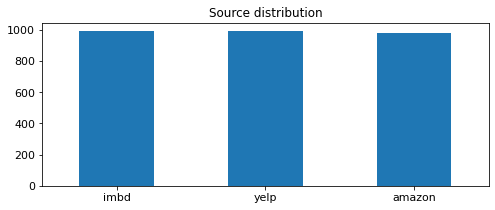

In [9]:
# categories
categories = ['amazon', 'imbd', 'yelp']
print(DATA.source_name.value_counts())
upper_bound = max(DATA.source_name.value_counts())+50
# plot barchart for DATA
DATA.source_name.value_counts().plot(kind = 'bar',
                                    title = 'Source distribution',
                                    ylim = [0, upper_bound],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

#### based on score

<Figure size 432x288 with 0 Axes>

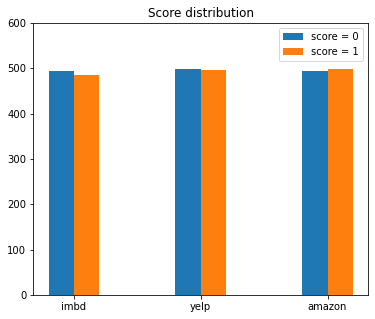

In [10]:
tmp = DATA.groupby(['source_name', 'score']).size()
score_0 = [tmp[0], tmp[2], tmp[4]]
score_1 = [tmp[1], tmp[3], tmp[5]]
plt.figure()
width = 6
barWidth = 0.2

fig = plt.subplots(figsize =(width, 5))
# x position for each bar
x1 = np.arange(3)
x2 = [x + barWidth for x in x1]
# set x axis value
plt.xticks((x1 + x2)/2, DATA.source_name.value_counts().index[:])
plt.bar(x1, score_0[:], width = barWidth, label ='score = 0')
plt.bar(x2, score_1[:], width = barWidth, label='score = 1')

plt.title('Score distribution')
plt.ylim(0, 600)

plt.legend()
plt.show()

#### Note :
Data is evenly distributed

### 3.2 Feature Creation

#### Tokenization of the **sentence**

In [11]:
# takes a like a minute or two to process
DATA['unigrams'] = DATA['sentence'].apply(lambda x: dmh.tokenize_text(x))

### 3.3 Feature subset selection
Heatmap

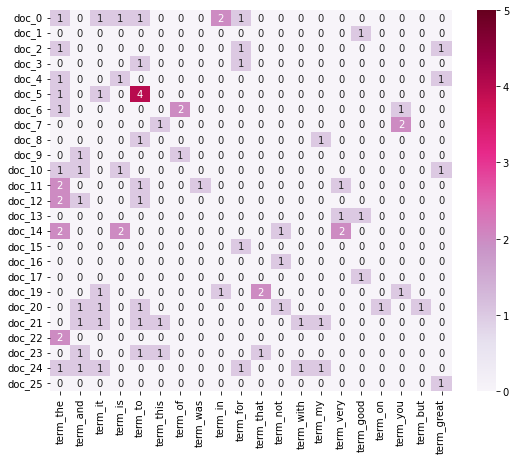

In [12]:
count_vect = CountVectorizer()

DATA_counts = count_vect.fit_transform(DATA.sentence) #learn the vocabulary and return document-term matrix
SIZE = 25
pd_counts = pd.DataFrame(DATA_counts.toarray())
# sum up each column
counts_sum = pd_counts.sum()
# sort into ascending order according to counts_sum
pd_counts = pd_counts[counts_sum.sort_values(ascending=False).index[:20]]

# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[pd_counts.columns[:20]]]
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(DATA.index)[0:SIZE]]
plot_z = (pd_counts[0:SIZE][pd_counts.columns[:SIZE]]).to_numpy()


df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=5, annot=True)



In [13]:
count_vect = CountVectorizer()
SIZE = 25
DATA_sample = DATA.sample(n = SIZE)
DATA_counts = count_vect.fit_transform(DATA.sentence) #learn the vocabulary and return document-term matrix

pd_counts = pd.DataFrame(DATA_counts.toarray())
# sum up each column
counts_sum = pd_counts.sum()
# sort into ascending order according to counts_sum
pd_counts = pd_counts[counts_sum.sort_values(ascending=False).index[:20]]

# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[pd_counts.columns[:20]]]
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(DATA_sample.index)[0:SIZE]]
plot_z = (pd_counts[DATA_sample.index.to_list()][pd_counts.columns[:SIZE]]).to_numpy()


df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=5, annot=True)



KeyError: "None of [Int64Index([1534, 2236, 2670,  409,  263, 1673, 1250, 2706,  386, 1168, 2805,\n            2424, 1297,  781, 1087,  315,  887, 2098, 2609, 2427, 2828,   32,\n             656, 1767, 2059],\n           dtype='int64')] are in the [columns]"

### 3.4 Dimensionality Reduction
See the data distribution of differest source and score

2D PCA

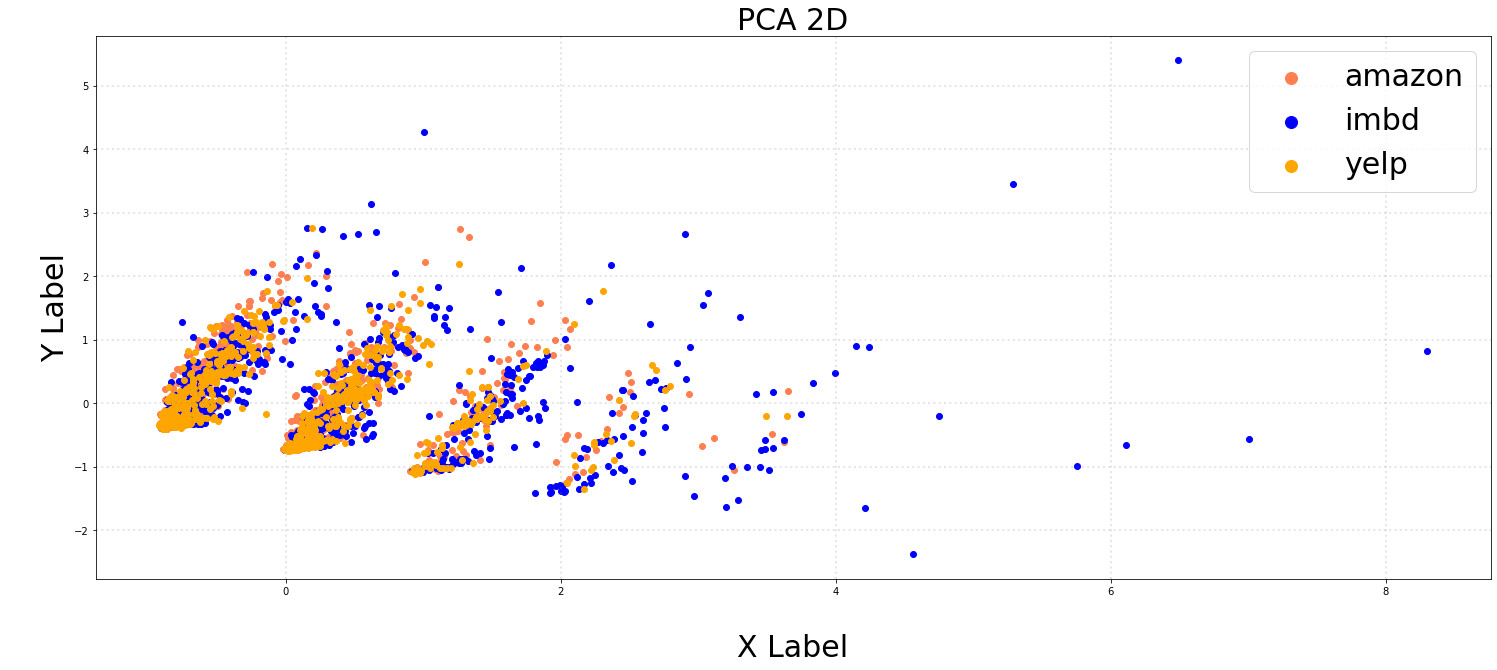

In [ ]:
X_reduced = PCA(n_components = 2).fit_transform(DATA_counts.toarray())
col = ['coral', 'blue', 'orange']

# plot
fig = plt.figure(figsize = (25,10))
ax = fig.subplots()

for c, category in zip(col, categories):
    xs = X_reduced[DATA['source_name'] == category].T[0]
    ys = X_reduced[DATA['source_name'] == category].T[1]
   
    ax.scatter(xs, ys, c = c, marker='o', label=category)

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label', fontsize = 30)
ax.set_ylabel('\nY Label', fontsize = 30)
ax.set_title('PCA 2D', fontsize = 30)
plt.legend(fontsize = 30, markerscale = 2 )
plt.show()

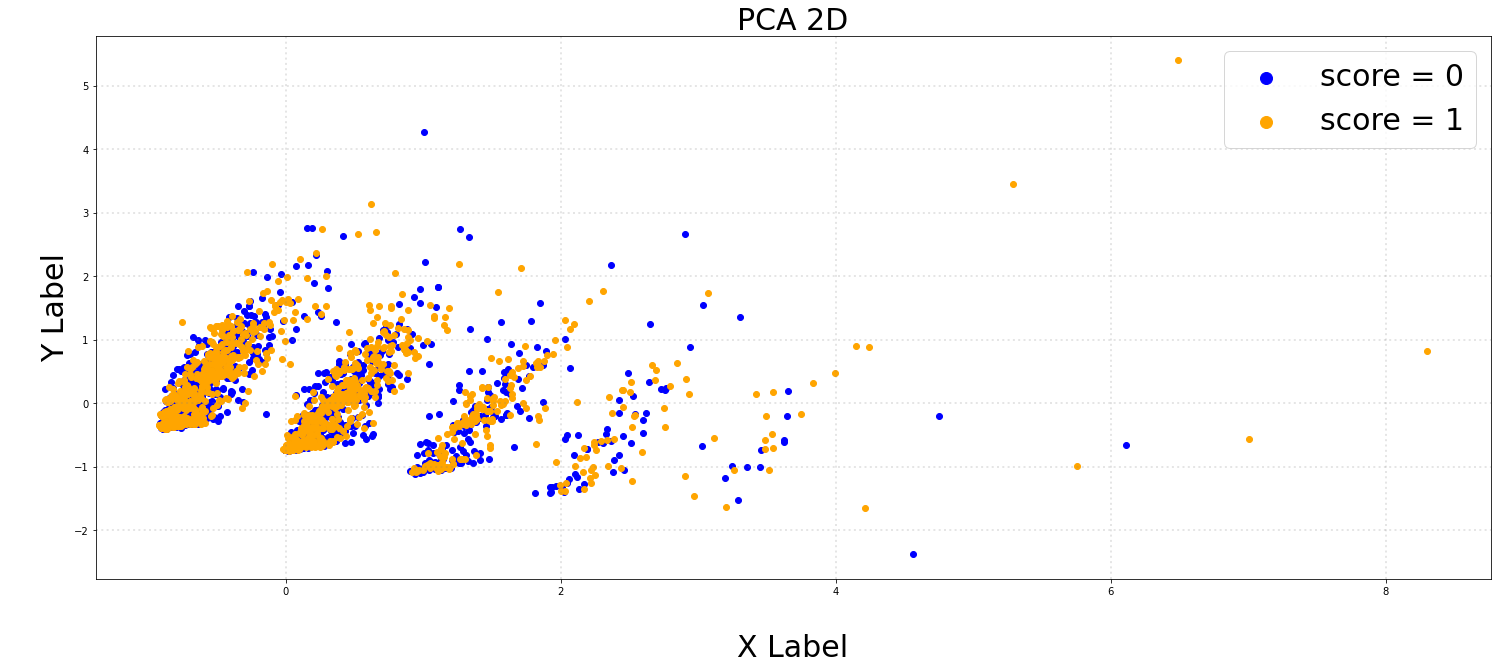

In [ ]:
X_reduced = PCA(n_components = 2).fit_transform(DATA_counts.toarray())
col = ['blue', 'orange']

# plot
fig = plt.figure(figsize = (25,10))
ax = fig.subplots()
categories_score = [0, 1]
for c, category in zip(col, categories_score):
    xs = X_reduced[DATA['score'] == category].T[0]
    ys = X_reduced[DATA['score'] == category].T[1]
   
    ax.scatter(xs, ys, c = c, marker='o', label='score = '+str(category))

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label', fontsize = 30)
ax.set_ylabel('\nY Label', fontsize = 30)
ax.set_title('PCA 2D', fontsize = 30)
plt.legend(fontsize = 30, markerscale = 2 )
plt.show()

3D PCA from two angle


In [14]:
X_reduced = PCA(n_components = 3).fit_transform(DATA_counts.toarray())
ANGLE = [[0, 0], [30, 30], [25, 10]]

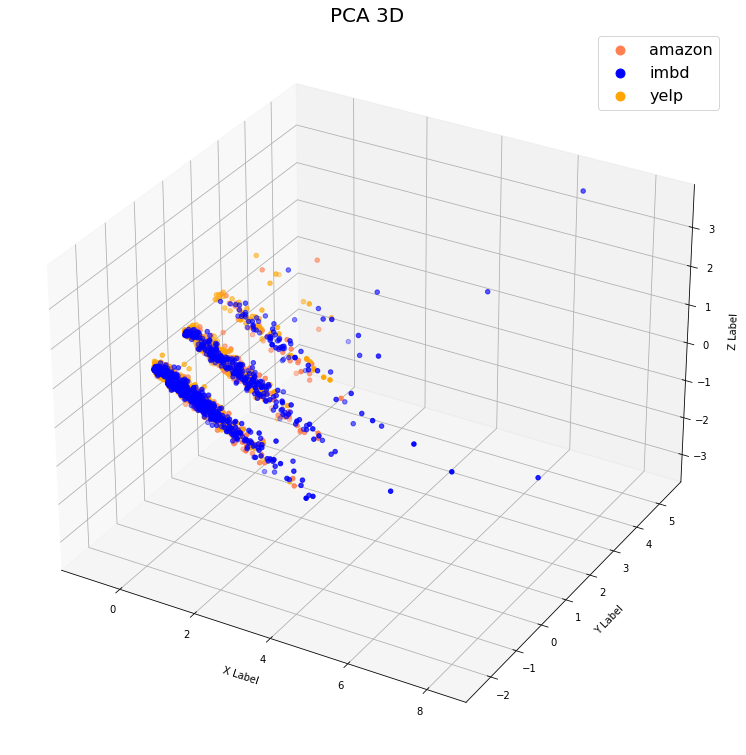

In [15]:
# plot
fig = plt.figure(figsize = (15,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
col = ['coral', 'blue', 'orange']
for c, category in zip(col, categories):
    xs = X_reduced[DATA['source_name'] == category].T[0]
    ys = X_reduced[DATA['source_name'] == category].T[1]
    zs = X_reduced[DATA['source_name'] == category].T[2]
    ax.scatter(xs, ys, zs, c = c, marker='o', label=category)

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
ax.set_zlabel('\nZ Label')

# ax.view_init(ANGLE[0][0], ANGLE[0][1])
ax.set_title('PCA 3D', fontsize = 20)
plt.legend(fontsize = 16, markerscale = 2 )
plt.show()


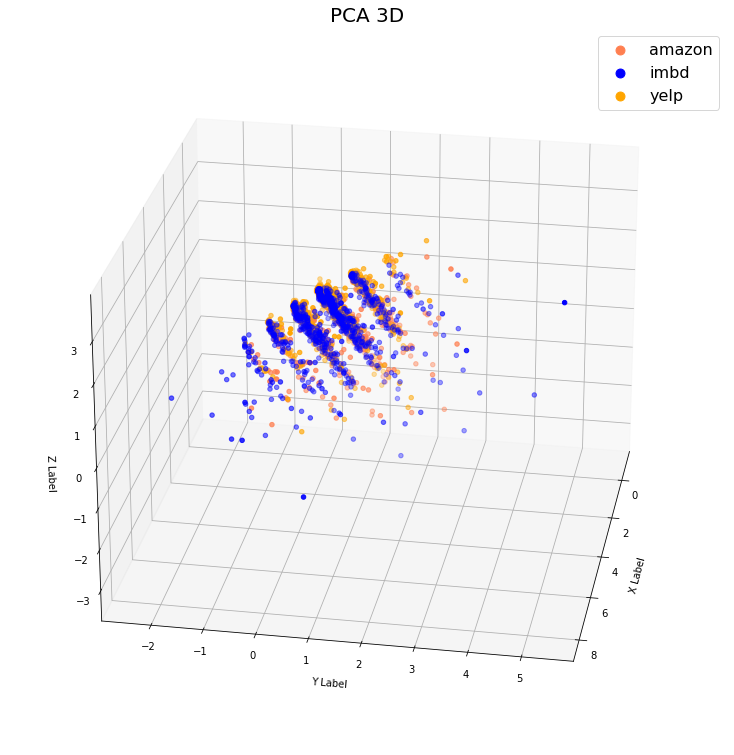

In [16]:
# plot
X_reduced = PCA(n_components = 3).fit_transform(DATA_counts.toarray())
fig = plt.figure(figsize = (15,10))
ax = Axes3D(fig, auto_add_to_figure=False)
col = ['coral', 'blue', 'orange']
fig.add_axes(ax)
ANGLE = [[0, 0], [30, 30], [25, 10]]
for c, category in zip(col, categories):
    xs = X_reduced[DATA['source_name'] == category].T[0]
    ys = X_reduced[DATA['source_name'] == category].T[1]
    zs = X_reduced[DATA['source_name'] == category].T[2]
    ax.scatter(xs, ys, zs, c = c, marker='o', label=category)

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
ax.set_zlabel('\nZ Label')

ax.view_init(ANGLE[2][0], ANGLE[2][1])
ax.set_title('PCA 3D', fontsize = 20)
plt.legend(fontsize = 16, markerscale = 2 )
plt.show()

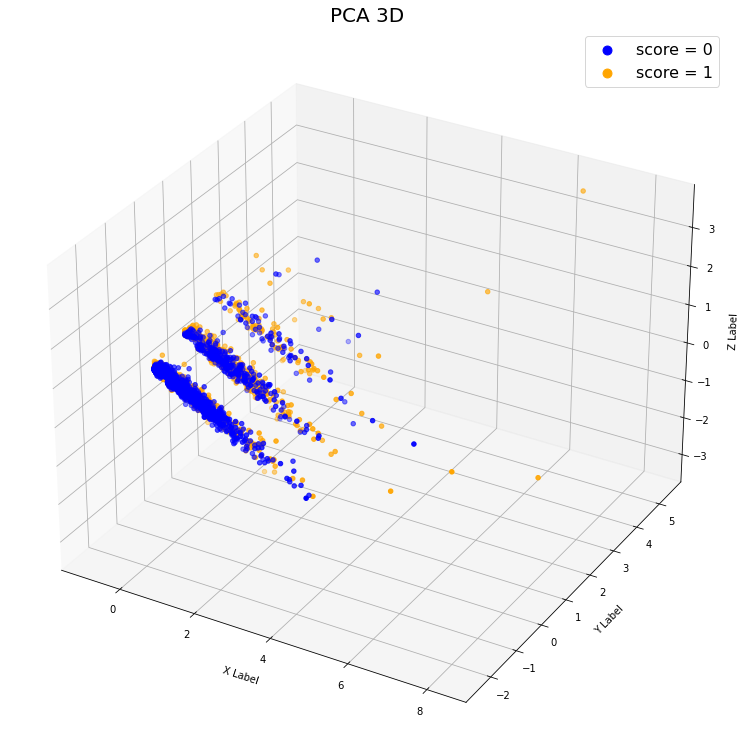

In [17]:
# plot
X_reduced = PCA(n_components = 3).fit_transform(DATA_counts.toarray())
col = ['blue', 'orange']

fig = plt.figure(figsize = (15,10))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ANGLE = [[0, 0], [30, 30], [25, 10]]
categories_score = [0, 1]

for c, category in zip(col, categories_score):
    xs = X_reduced[DATA['score'] == category].T[0]
    ys = X_reduced[DATA['score'] == category].T[1]
    zs = X_reduced[DATA['score'] == category].T[2]
    ax.scatter(xs, ys, zs, c = c, marker='o',label='score = '+str(category))

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
ax.set_zlabel('\nZ Label')

# ax.view_init(ANGLE[0][0], ANGLE[0][1])
ax.set_title('PCA 3D', fontsize = 20)
plt.legend(fontsize = 16, markerscale = 2 )
plt.show()

### 3.5 Attribute Transformation / Aggregation

In [26]:
term_frequencies = []
for j in range(0,DATA_counts.shape[1]):
    term_frequencies.append(sum(DATA_counts[:,j].toarray()))

In [23]:
# a better plot
# Plot the distribution using higher frequency features.
SIZE = 50 # how many phrase to display
sorted = pd.DataFrame(term_frequencies, columns=['freq'])
sorted = sorted.sort_values(by=['freq'], ascending=False)
idx = (sorted.index).to_list()[:SIZE]

fig = px.bar(
             x=count_vect.get_feature_names_out()[idx], y=sorted[:SIZE]['freq'].to_list(),
             labels = {'x':'Phrase', 'y':'Frequencies'},
             category_orders = count_vect.get_feature_names_out()[idx],
             title='Top '+str(SIZE) + ' used phrase'
            )
fig.update_traces(texttemplate=sorted[:SIZE]['freq'].to_list(), textposition='outside')
fig.show()

### 3.6 Discretization and Binarization
binarize **sourece_name_encoded**

In [25]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(DATA.source_name_encoded)
DATA['bin_source'] = mlb.transform(DATA['source_name_encoded']).tolist()
DATA[1500:1510]

,sentence,score,source_name,source_name_encoded,score_encoded,unigrams,bin_source
1523,20th Century Fox's ROAD HOUSE 1948) is not onl...,0,imbd,1,False,"[20th, Century, Fox, 's, ROAD, HOUSE, 1948, ),...","[0, 1, 0]"
1524,Full of unconvincing cardboard characters it i...,0,imbd,1,False,"[Full, of, unconvincing, cardboard, characters...","[0, 1, 0]"
1525,From here on the Widmark character turns unint...,0,imbd,1,False,"[From, here, on, the, Widmark, character, turn...","[0, 1, 0]"
1526,His losing his marbles so early in the proceed...,0,imbd,1,False,"[His, losing, his, marbles, so, early, in, the...","[0, 1, 0]"
1527,And if that isn't enough of a mess of a movie ...,0,imbd,1,False,"[And, if, that, is, n't, enough, of, a, mess, ...","[0, 1, 0]"
1528,Whatever prompted such a documentary is beyond...,0,imbd,1,False,"[Whatever, prompted, such, a, documentary, is,...","[0, 1, 0]"
1529,(very serious spoilers) this movie was a huge ...,0,imbd,1,False,"[(, very, serious, spoilers, ), this, movie, w...","[0, 1, 0]"
1530,there are so many problems i dont know where t...,0,imbd,1,False,"[there, are, so, many, problems, i, dont, know...","[0, 1, 0]"
1531,the cast was great.,1,imbd,1,True,"[the, cast, was, great, .]","[0, 1, 0]"
1532,steve martin delivers a really funny performan...,1,imbd,1,True,"[steve, martin, delivers, a, really, funny, pe...","[0, 1, 0]"


## 4. Data Exploration
see cosine similarity between 3 sentences, each from different source

In [30]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = DATA.iloc[50]
random_record_1 = random_record_1['sentence']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = DATA.iloc[1100]
random_record_2 = random_record_2['sentence']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = DATA.iloc[2150]
random_record_3 = random_record_3['sentence']
document_to_transform_3.append(random_record_3)

# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.049147
Cosine Similarity using count bw 1 and 3: 0.000000
Cosine Similarity using count bw 2 and 3: 0.312772
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000
